## E-Bike survey analysis

This notebook contains my analysis for how to charactrize the survey data gathered by the City of Toronto regarding E-Bike usage, and to discern if there were any patterns in the responses which could predict a particular answer to the question **"Does your household have access to any of the following types of private motorized vehicles?"** 

The conclusions from this data analysis are presented in the **Conclusions** cell, at the bottom of the notebook.  My responses to the challenge question are presented therein.  I began by importing the tools needed to load the data and perform EDA:

In [77]:
import pandas as pd
import numpy as np
from collections import OrderedDict, defaultdict

In [6]:
survey_data = pd.read_csv("https://raw.githubusercontent.com/samtalasila/e-bike-survey-response-results/master/E-Bike_Survey_Responses.csv")
print(survey_data.shape)
survey_data.head()

(2238, 22)


,Timestamp,What age range do you fall in?,Sex,How would you describe your level of physical health?,What level of education have you reached?,What is your household income?,Which category best describes your employment?,What Toronto district is your primary address located in?,On average what distance do you travel most days of the week?,On average how long is your commute?,...,Do you support any of the following statements?,When you use Toronto's Multi-Use Trails do you mostly,Are you aware that the Multi-Use Paths have a speed limit of 20 km/h?,Have you witnessed a collision or conflict on a trail between,Do you think more should be done to manage trail users who do not respect the 20 km/h speed limit?,Currently any kind of e-bike may use a multi-use path if they are propelled by pedaling only and those propelled by motor power may be fined,When you use Toronto's bicycle lanes do you mostly,Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power may be fined,With regards to illegal use of bicycles and e-bikes on sidewalks should the City,Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City
0,2013-04-10 12:10,35 to 49,Male,Good,Post graduate,$100K+,Self Employed,Central Toronto York or East York,Under 2 km,15 minutes or less,...,On scooter type e-bikes the pedals are unneces...,drive a motor propelled e-bike,No,pedestrians and/or runners a conflict relating...,No - the trails are fine as they are,The bylaw should be modified to allow any kind...,drive a scooter type e-bike propelled by an el...,The bylaw should be modified to allow e-bikes ...,be tolerant of bikes and e-bikes on the walksi...,Institute a speed limit for sidewalks
1,2013-04-10 12:30,18 to 34,Male,Excellent,University degree,$40K to $59K,Full Time,Central Toronto York or East York,10 - 20 km,30 - 44 minutes,...,On scooter type e-bikes the pedals are unneces...,I very rarely use any of Toronto's Multi-Use P...,No,I am not aware of any conflicts on the trails,No - the trails are fine as they are,No changes are necessary to the existing bylaw,drive a scooter type e-bike propelled by an el...,The bylaw should be modified to allow e-bikes ...,maintain the existing programs for signage edu...,Do nothing
2,2013-04-10 12:33,50 to 64,Male,Good,University degree,$40K to $59K,Self Employed,Central Toronto York or East York,10 - 20 km,15 minutes or less,...,Most scooter type e-bikes are wider than a bic...,cycle I very rarely use any of Toronto's Multi...,No,I am not aware of any conflicts on the trails,Yes - more signage Yes - more enforcement (tic...,No changes are necessary to the existing bylaw,ride a road bicycle or a fixie,No changes are necessary to the existing bylaw,increase signage increase enforcement increase...,only wheelchairs at walking speed
3,2013-04-10 12:52,50 to 64,Male,Good,4 years university no degree,$80K to $99K,Self Employed,Central Toronto York or East York,Under 2 km,15 minutes or less,...,On scooter type e-bikes the pedals are unneces...,cycle,No,a conflict between cyclists and pedestrians a ...,Yes - more signage Yes - more enforcement (tic...,Motorized vehicles should generally not be all...,ride a commuter or cruiser style bicycle,Motorized vehicles should generally not be all...,increase signage increase enforcement,Update the definition of a personal mobility d...
4,2013-04-10 13:24,18 to 34,Male,Very good,College or trade school diploma,$40K to $59K,Self Employed,Central Toronto York or East York,5 - 10 km,15 minutes or less,...,Most scooter type e-bikes are wider than a bic...,cycle I very rarely use any of Toronto's Multi...,No,I am not aware of any conflicts on the trails,No - the trails are fine as they are,Motorized vehicles should generally not be all...,ride a road bicycle or a fixie,Motorized vehicles should generally not be all...,maintain the existing programs for signage edu...,Upda

### First impression of the data and assumptions

Based on my first examination of the data, the responses in each column can be modeled as one of three types:
- ordinal; ordered string responses
- binary; yes / no, male / female responses
- categorical; un-ordered string responses

So the way forward to begin attacking the problem is to re-encode each column appropriately.  The appropriate encoder for each response type (in scikit-learn anyhow) is:
- `CategoricalEncoder(encoding='ordinal')` for ordinal data
- `LabelEncoder(n=2)` for binary data
- `CategoricalEncoder(encoding='onehot')` for categorical data

Except I don't have a version of scikit-learn that has ordinal encoding (it's in pre-release alpha version 0.20, I have 0.19.1)  So I'll assume that all non-binary features are categorical features, ignoring the ordinal nature of many of the responses.  

However I choose to represent the data, I should make sure to isolate the responses my model will try to predict.  Also, we want to drop any rows where the response is missing:

In [19]:
response_q = 'Does your household have access to any of the following private motorized vehicles?'
positive_label = 'No - I do not have access to a private motorized vehicle'

labels = survey_data[response_q]
predictors = survey_data.drop(columns=[response_q, 'Timestamp'])
missing_values_per_predictor = predictors.isna().sum()

print("Original data was shape: ", survey_data.shape)
print("Predictors have shape: ", predictors.shape)

print("Found ", labels.isna().sum(), " rows with response missing")
print("Found ", missing_values_per_predictor.sum(), " number of missing values total among all predictor columns")

Original data was shape:  (2238, 22)
Predictors have shape:  (2238, 20)
Found  0  rows with response missing
Found  135  number of missing values total among all predictor columns


Let's do a bit of simple cleaning.  We will fill missing values with 'NA', and make sure that when we break down the label distribution, we get the expected number of positive and negative cases that together form the total:

In [20]:
predictors = predictors.fillna(value='NA')
print("Found ", len(set(labels)), "different responses")

positives = 0
negatives = 0
for label in labels:
    if label.strip().startswith(positive_label):
        positives += 1
    else:
        negatives += 1
print("Got ", positives, " matches to specific answer")
print("Got ", negatives, " non-mathces to specific answer")
print("Expected total of ", labels.shape[0], " responses, got ", positives + negatives)

Found  123 different responses
Got  524  matches to specific answer
Got  1714  non-mathces to specific answer
Expected total of  2238  responses, got  2238


## Initial assumptions about the data are wrong

We should pause here to reflect on a two points revealed by our EDA so far.

1. There are 123 different answers to the question we are trying to predict as response.  We cannot hope to predict 123 separate classes with only 2238 data points, so we will treat this as a binary classification problem.

2. This makes me want to check the variability in the answers to each other question.  I inferred from a scan of the first five records that the responses to each question were codified; that is, I could associate a categorical or ordinal code to each text response.  But counting the number of different responses to each question shows that this is *not* the case:

In [21]:
question_response_complexity_dict = OrderedDict()
for k in predictors.keys():
    question_response_complexity_dict[k] = ""
    
print("Number of questions: ", len(predictors.keys()))  
print("Cardinality of responses to each survey question:\n")    
for k in question_response_complexity_dict.keys():
    data = predictors[k]
    cardinality = len(set(data))
    question_response_complexity_dict[k] = cardinality
    print(k, "\t", cardinality)


Number of questions:  20
Cardinality of responses to each survey question:

What age range do you fall in? 	 6
Sex 	 13
How would you describe your level of physical health? 	 13
What level of education have you reached? 	 25
What is your household income? 	 7
Which category best describes your employment? 	 34
What Toronto district is your primary address located in? 	 69
On average what distance do you travel most days of the week? 	 6
On average how long is your commute? 	 7
Which transportation option do you end up using most often? 	 33
Do you support any of the following statements? 	 534
When you use Toronto's Multi-Use Trails do you mostly 	 89
Are you aware that the Multi-Use Paths have a speed limit of 20 km/h? 	 2
Have you witnessed a collision or conflict on a trail between 	 221
Do you think more should be done to manage trail users who do not respect the 20 km/h speed limit? 	 135
Currently any kind of e-bike may use a multi-use path if they are propelled by pedaling only

## Revising my assumptions of the data

It looks like only a small minority of questions have low cardinality: age, income, average commute distance, length of daily commute, aware of speed limits.  What about the distribution of responses to each question?  Let's look at a quick histogram of how frequently each response to the corresponding question appears in the data.  We can do this for each question using `pd.Series.value_counts()` and arranging the histograms into a grid:

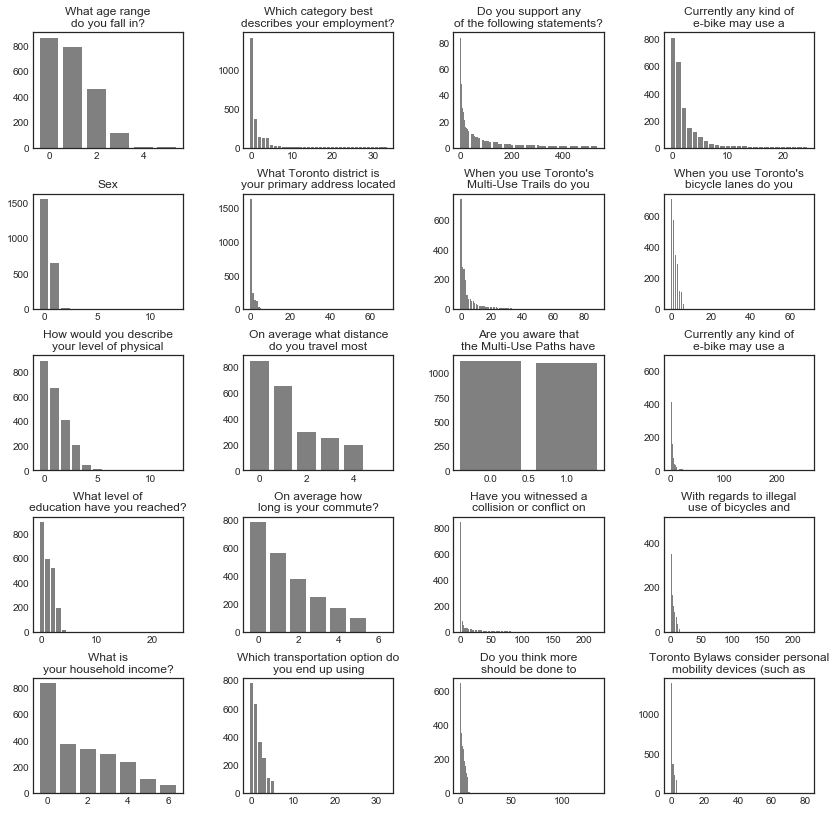

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')    
    
### look at hist of responses to each predictor
fig, ax = plt.subplots(5, 4, figsize=(14, 14))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
r = 0
c = 0

for i,k in enumerate(predictors.keys()):
    data = [d for _, d in predictors[k].value_counts().items()]
    names = [n for n, _ in predictors[k].value_counts().items()]
    
    r = i % 5
    c = (i - r) % 4
    title_length = min(len(k.split()),8)
    title_line_one = ' '.join(k.split()[0 : title_length // 2])
    title_line_two = ' '.join(k.split()[title_length // 2 : title_length])
    title = title_line_one + "\n" + title_line_two
    ax[r,c].bar([i for i in range(len(data))], data, color='gray')
    ax[r,c].set_title(title)

## Obervations about the data, deciding on an approach to predict the response

The histograms reveal a few things about the data:

1) Most of the questions have a few common responses (likely provided in the survey), followed by a long tail of principly unique responses that seem provided free-form. If I were to drop or group the free-form answers into one factor level (e.g 'other'), I could model most questions as categorical factors.

2) A second way would be to model each answer in the responses as a bag of words, and turn each answer in to a sparse bag of vectorized features.

Without wanting to get too deep into reverse engineering the survey, I'll try to model the collection of responses first as a set of categorical variables, and then later as a stemmed bag of words.

## Modeling predictors as categorical variables

In [23]:
# Go through the predictors, find those answers in each question to be grouped into 'other'
# N.B: using a poorly chosen heuristic of 4 is not great, but based on my reading of
# the data manually, it seems an okay heuristic. 

# One of the ways to improve this would be to automatically determine an appropriate threshold via an information theoretic measure
# for each predictor, but this is out of scope for a first attempt.

replace_as_other = {k: [] for k in predictors.keys()}
for k in predictors.keys():
    replace_as_other[k] = [n for n, d in predictors[k].value_counts().items() if d < 4]

# perform the in-place replacement
for k in predictors.keys():
    predictors.loc[predictors[k].isin(replace_as_other[k]), k] = 'unusual answer'
    

Let's re-examine the distribution of answers to each question now:

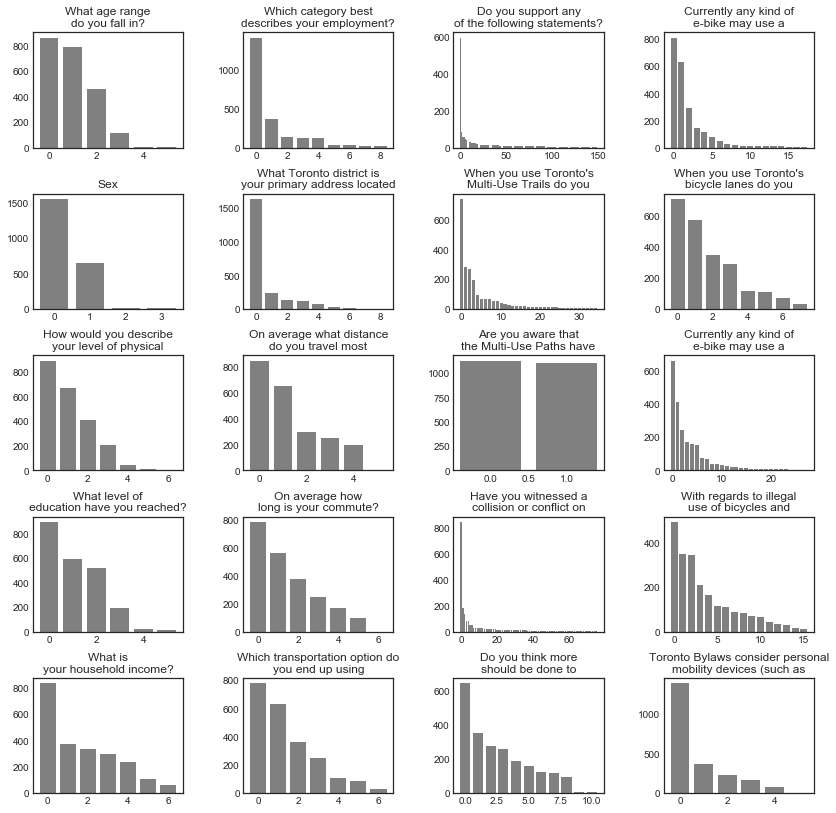

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')    
    
### look at hist of responses to each predictor
fig, ax = plt.subplots(5, 4, figsize=(14, 14))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
r = 0
c = 0

for i,k in enumerate(predictors.keys()):
    data = [d for _, d in predictors[k].value_counts().items()]
    names = [n for n, _ in predictors[k].value_counts().items()]
    
    r = i % 5
    c = (i - r) % 4
    title_length = min(len(k.split()),8)
    title_line_one = ' '.join(k.split()[0 : title_length // 2])
    title_line_two = ' '.join(k.split()[title_length // 2 : title_length])
    title = title_line_one + "\n" + title_line_two
    ax[r,c].bar([i for i in range(len(data))], data, color='gray')
    ax[r,c].set_title(title)

Great.  Now, we encode the answers to each question as categotical 'one-hot' answers, and train models to accurately predict our response. Also we encode the labels to be predicted.

In [25]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

# Encode labels in the response
label_encoder = {positive_label: 1}
encoded_labels = [label_encoder.get(r,0) for r in labels]
y = np.array(encoded_labels)

# Encode the features in the predictors, imputing missing values
encoder_pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)), 
    ("imputer", Imputer(missing_values=np.nan, 
                    strategy="mean",
                    axis=0))
                    ])

features = predictors.to_dict('records')
X = encoder_pipeline.fit_transform(features)

# Make sure we get sensible features
print("shape of X: ", X.shape)
print("type of X: ", type(X))
print("Any NaN or infinity? ", np.isnan(X).sum())

shape of X:  (2238, 417)
type of X:  <class 'numpy.ndarray'>
Any NaN or infinity?  0


In [29]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# CV on logistic regression
lr_clf = LogisticRegressionCV()
lr_clf.fit(X,y)

# CV on n_estimators, max_depth for both GBC, RFC
param_grid_dict = {'n_estimators': [5,10,20,50,100,200], 'max_depth': [2,4,6,8,10], 'min_samples_leaf': [1,3,5,10,15]}

rfc = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
gbc = GradientBoostingClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

random_forest_clf = GridSearchCV(estimator=rfc, param_grid=param_grid_dict, n_jobs=2)
random_forest_clf.fit(X, y) 

gbc_clf = GridSearchCV(estimator=gbc, param_grid=param_grid_dict, n_jobs=2)
gbc_clf.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': [5, 10, 20, 50, 100, 200], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 3, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## Examining the model performances and the best features

Let's take a look at a crude breakdown of the best scoring models, and what hyperparameters define them:

In [30]:
print("Model: Logistic Regression")
print("Model best params: ", lr_clf.C_)
print("Model best score: ", lr_clf.score(X,y))
print("\n")

for name, model in zip(["Random Forest", "Gradient Boosted Classifier"],[random_forest_clf, gbc_clf]):
    print("Model: ", name)
    print("Model best params: ", model.best_params_)
    print("Model best score: ", model.best_score_)
    print("\n")
 

Model: Logistic Regression
Model best params:  [0.04641589]
Model best score:  0.819928507596068


Model:  Random Forest
Model best params:  {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 10}
Model best score:  0.7783735478105451


Model:  Gradient Boosted Classifier
Model best params:  {'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 100}
Model best score:  0.7949061662198391




## General comments

Since we aren't training this model to generalize to new data but rather to understand our survey data set, I cheated and did not follow best data hygene, which is to make sure training, test and validation data are strictly exclusive.  Despite this we can still learn a lot from examining the distribution of model scores.  The reported best score is accuracy over a held out fold of training data, which for binary classification is the proportion of correctly classified elements.  

Each classifier I trained performed about equally, with perhaps a minor difference between the random forests and the logistic regression classifier, but on a data set this small with the cross-validation scheme used, we cannot say with certainty.  Let's proceed to unpack the most important features by classifier.

In [31]:
# Unpack the Logistic Regression classifier
best = lr_clf.coef_
feature_importance = 100.0 * (best / best.max())

# Retrieve the feature names
feature_names = encoder_pipeline.named_steps['vectorizer'].get_feature_names()
indices = np.argsort(np.abs(feature_importance))

top_n = 10
print("\nTop ", top_n, " feature ranking:\n")
for f in range(top_n):
    print(f + 1, feature_names[indices[0,f]], feature_importance[0,indices[0,f]])




Top  10  feature ranking:

1 Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power may be fined =The bylaw should be modified to allow all kinds of e-bikes to drive in bicycle lanes without pedalling but there should be some restrictions (eg width weight speed) The bylaw should be modified to allow e-bikes to use bicycle lanes in suburban areas but not in busy downtown bicycle lanes -0.002259858570004792
2 Currently any kind of e-bike may use a multi-use path if they are propelled by pedaling only and those propelled by motor power may be fined =The bylaw should be modified to allow any kind of e-bike including scooter type e-bikes use the trail The bylaw should be rescinded so that any kind of recreational motor vehicle can drive on the trail -0.0035924071522565903
3 Do you support any of the following statements?=scooter style e-bikes are different than pedal assisted bicycle type e-bikes and should not be consi


Top  10 Random Forest  feature ranking:
(indexed feature, question and response, feature weight) 

* 394 * Which transportation option do you end up using most often?=bicycle 0.11567635174620203
* 396 * Which transportation option do you end up using most often?=private motor vehicle (car truck SUV van motorcycle gas limited speed motorcycle or moped) 0.09583211804895805
* 329 * What is your household income?=$100K+ 0.07431625581990067
* 315 * What Toronto district is your primary address located in?=Central Toronto York or East York 0.05980535649752441
* 324 * What age range do you fall in?=18 to 34 0.043371363923641194
* 330 * What is your household income?=$20K to $39K 0.037108528633083
* 335 * What is your household income?=Under $20K 0.021877284680972234
* 398 * Which transportation option do you end up using most often?=transit 0.017480374691445345
* 300 * On average what distance do you travel most days of the week?=5 - 10 km 0.015040937628223668
* 382 * When you use Toronto's 

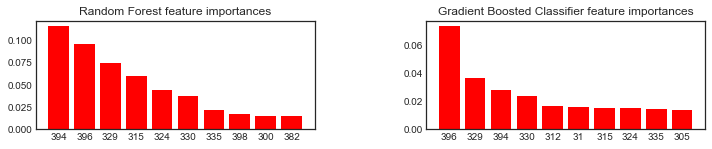

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
from sklearn.ensemble import partial_dependence

for i, (name, model) in enumerate(zip(["Random Forest", "Gradient Boosted Classifier"],[random_forest_clf, gbc_clf])):

    best = model.best_estimator_
    importances = best.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in best.estimators_],
    #             axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("\nTop ", top_n, name, " feature ranking:")
    print("(indexed feature, question and response, feature weight) \n")
    for f in range(top_n):
        print("*",indices[f],"*", feature_names[indices[f]], importances[indices[f]])

    # Plot the feature ranking
    title = name + " feature importances"
    ax[i].bar(range(top_n), importances[indices[0:top_n]],
           color="r", align="center")
    ax[i].set_xticks(range(top_n))
    ax[i].set_xticklabels(indices[0:top_n])
    ax[i].set_title(title)



## Feature importances

The plots above reveal the most important 10 features for the random forest model as well as the gradient boosted regression tree classifier model.  The overlap between both sets of features is large, which is encouraging.  However, it only identifies those features which are most informative for constructing the trees used to separate positive from negative responders, and not the importance of the directionality of the response.  

To find out which features drive a responsdent to answer affirmatively (i.e "*No - I do not have access to a private motorized vehicle*" to the question "**'Does your household have access to any of the following private motorized vehicles?'**"), we need to resort to a different analysis.  Fortunately, the gradient boosted regression tree classifier model allows us to efficiently calculate just this relationship, termed *partial dependence*.  We do so below for the top five features:

In [76]:
# shorten the names of the features, removing non-informative words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

def strip_to_three_max(q_or_a):
    ''' strip a multi word question or answer down to a max
    length of its first three words '''
    words = [word for word in q_or_a.split() if word not in stops]
    new_len = min(3, len(words))
    return " ".join([w for w in words[0:new_len]])

def repro(name):
    ''' shorten the feature name '''
    
    parts = name.strip().split("=")
    if len(parts) != 2:
        return name
    
    q, a = parts
    return strip_to_three_max(q) + " = " + strip_to_three_max(a)
    
    
reprocessed_features = [repro(f) for f in feature_names]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zamparol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


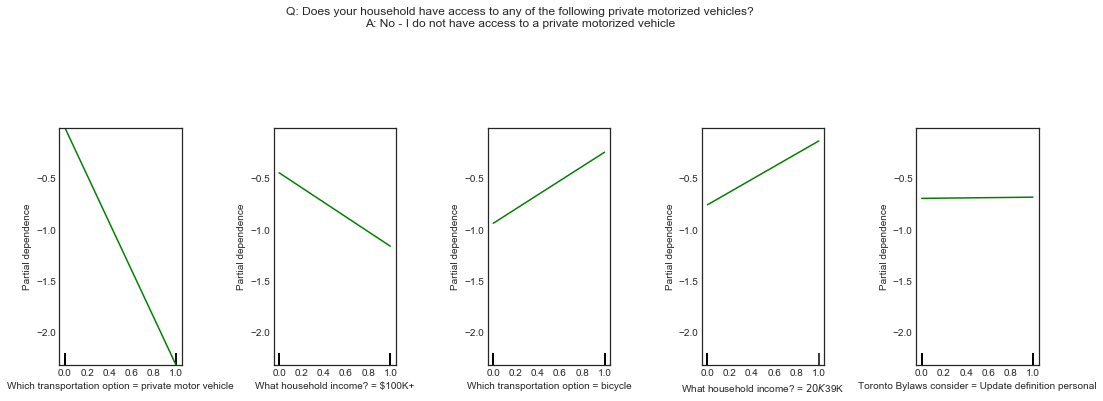

In [75]:
from sklearn.ensemble import partial_dependence as pdep

top_n = 5
model_name = "Gradient Boosted Regression Tree"
model = gbc_clf
    
best = model.best_estimator_
importances = best.feature_importances_
indices = np.argsort(importances)[::-1] 

top_n_features = [indices[f] for f in range(top_n)]

# Plot the feature ranking
title = name + " feature importances"
fig, axs = pdep.plot_partial_dependence(best, X, top_n_features, feature_names=reprocessed_features, n_cols=top_n)
fig.set_size_inches(16, 6)
fig.suptitle('Q: ' + response_q + '\n' + "A: " + positive_label)
plt.subplots_adjust(wspace=0.75)  


## Conclusions

From the scikit-learn [website](http://scikit-learn.org/stable/modules/ensemble.html#partial-dependence): *"Partial dependence plots (PDP) show the dependence between the target response and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response [1] as a function of the ‘target’ features [2]."*

So what can we learn from these five plots?  The absolute value of the Y-axis in the plots is less informative for us than the slope, but we can use the slope to gain some insight from the model.  I will comment on each figure in turn.  I will say that the respondent answers affirmativey if they respond *No - I do not have access to a private motorized vehicle* to the target question **'Does your household have access to any of the following private motorized vehicles?'**:

1) If the respondent said they commonly used a private motor vehicle, they were not going to answer affirmatively.  This is an encouraging sanity check on the model.

2) Similarly, if the respondent came from a household with a combined income of over $100k+, it is reasonable to expect they either owned a private vehicle.  

3) If the respondent most frequently used a bicycle for transportation, they were more likely to answer affirmatively.

4) If the respondent had a household income of between 20k-39k, they were more likely to respond affirmatively.

5) There is little we can say about the bylaws definition, since the slope is quite flat.

This is only a cursory look at the features.  Partial dependence can also be calcuated for pairs or triples of interacting features.  While acknowledging this would be the next natural step, I think it is out of scope for this exercise.

### Q : Which models did you consider? Which Model did you choose and why? How good was it?

Since the question posed was a binary decision problem, I tried three possible models:

1) A logistic regression model

2) A random forest model

3) A gradient boosted regression trees model

I chose the logistic regression model as a baseline; it is a simple model, but one whose model structure is flat, and where the regularization on the parameters has to be extensive if you want an interpretation of the model decisions. 

I chose to also look at both tree based methods because the nodes chosen to represent decision rules during the fitting process yields a ready interpretation: the tree splits on variables that separate the data by target response, and the response to each predictor question tell you which responses were most informative.  In addition, they are both ensemble models which are known to 

Furthermore, the gradient boosting regression trees model admits efficient calculation of partial dependence, which is a more direct way to determine the effect, positive or negative, of a particular response to a particular predictor question.  

As to how good the model was, the GBRT was statistically close to the performance of the logistic regression baseline.  This suggests to me that it is 'good enough' without further re-training the model with best hyperparameters for `{n_estimators, max_depth, min_samples_leaf}` and then re-tuning the learning rate.  Another method for boosting performance would be to create a larger ensemble of all three models, that predicts class by majority vote.  The trade off here is that for a (potential) amount of increased accuracy, we make the problem of model interpretation much more difficult.

### What was the pattern of missing values? Was it random? Could those be inferred from the context?

See the accompanying `Missing-data` notebook for details. For a given element of the survey `(i,j)`, I looked at two simple tests to determine if there was any dependency of the missingness on row or column.  There were 2238 rows in the survey, 22 columns, and a total of 135 missing values in the data.  

Counting by row, most rows had no missing data.  Of those that had any, the range was from 1 missing value up to a maximum of 9 missing values [see second figure].  Based on that, I saw no evidence to characterize the row-wise missing data pattern further.  

The columns, however, show a large bias for missing data in the question "What is your household income?" [see first figure].  There were some minor effects for questions "Sex",  "What level of education have you reached?", and "Which category best describes your employment?".  

All together, the column-wise sums of missing data suggest we can rule out a model of missing data in which data is  missing completely at random (i.e with no dependency on either row, column or value).  The strong observed frequency of missing data for the question "What is your household income?" relative to all others suggests that the probability of data to be missing conditioned on a certain column is not the same across all columns.  I am not sure if this is enough evidence to support the hypothesis that people were reluctant to fill in this question because of their household income status.  

I am not sure what is meant by the third part of the question "Could those be inferred from the context?": do you mean could the data be imputed?  Or could the likelihood of a question lacking an answer given other answers by the same respondent?  In the second case, I suspect we do not have enough data to support such a hypothesis.  There is just too little data.

### Which features were significant in predicting the target response?

This question was central to my analysis and is treated extensively under the **General comments** and **Feature importances** cells of this notebook.  I won't repeat the results here.

### If you could re-design the survey for next year, what question(s) would you add or remove in order to improve the precision of the prediction?

I do not have any experience in survey design, but I will try to answer as best I can.  If the desired effect of the survey is to figure out how to predit whether the respondents do not have access to a private motorized vehicle, then this should simply be included as a yes/no question.  I also suggest that instead of asking respondents to provide where they live by geographical region, why not instead ask them to provide a postal code.  This would allow for the survey analysis to be performed on several different levels (from the very small to the more broad areas through mergeing proximal codes).  